In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopy.geocoders
from geopy.geocoders import Nominatim, GoogleV3
from sklearn.linear_model import LinearRegression
import numpy as np
import re
import config
from geopy import distance

%matplotlib inline
pd.set_option('display.max_colwidth', -1) #setting used to display the full links properly

In [2]:
#instantiate geocoder
geolocator = Nominatim(user_agent='my_app/1')
geolocator_google = GoogleV3(api_key=config.gmaps_api_key)

## Read file and clean variables

In [3]:
#read csv
df = pd.read_csv('data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68161 entries, 0 to 68160
Data columns (total 11 columns):
month                  68161 non-null object
town                   68161 non-null object
flat_type              68161 non-null object
block                  68161 non-null object
street_name            68161 non-null object
storey_range           68161 non-null object
floor_area_sqm         68161 non-null float64
flat_model             68161 non-null object
lease_commence_date    68161 non-null int64
remaining_lease        68161 non-null object
resale_price           68161 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 5.7+ MB


In [4]:
df.head()

#data is complete and very clean
# data 'cleaning' would just be to convert the remaining lease into a float for analysis

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [5]:
df.remaining_lease.unique()

array(['61 years 04 months', '60 years 07 months', '62 years 05 months',
       '62 years 01 month', '63 years', '61 years 06 months',
       '58 years 04 months', '59 years 08 months', '59 years 06 months',
       '60 years', '62 years 08 months', '61 years', '60 years 10 months',
       '59 years 03 months', '61 years 05 months', '60 years 04 months',
       '62 years', '60 years 03 months', '63 years 09 months',
       '61 years 01 month', '61 years 10 months', '58 years 06 months',
       '59 years 04 months', '62 years 11 months', '60 years 08 months',
       '93 years 08 months', '93 years 07 months', '60 years 01 month',
       '94 years 08 months', '78 years 04 months', '60 years 06 months',
       '62 years 06 months', '58 years', '70 years 08 months',
       '63 years 04 months', '63 years 06 months', '67 years 07 months',
       '61 years 07 months', '68 years 02 months', '68 years 03 months',
       '56 years', '67 years 09 months', '67 years 05 months',
       '63 years 07

In [6]:
## remaining lease info is structured as "<year> years <month> months", and "<year> years" if months is zero.
# since it's so structured, can extract this info using a simple function
def get_remaining_lease(rem_lease):
    rem_lease = rem_lease.split(' ')
    if len(rem_lease) > 2:
        return float(rem_lease[0]) + float(rem_lease[2])/12
    if len(rem_lease) == 2:
        return float(rem_lease[0])

df.remaining_lease = df.remaining_lease.apply(get_remaining_lease)

In [7]:
df.remaining_lease.describe()

count    68161.000000
mean     74.603615   
std      12.540101   
min      45.750000   
25%      65.083333   
50%      74.583333   
75%      83.583333   
max      96.666667   
Name: remaining_lease, dtype: float64

## EDA

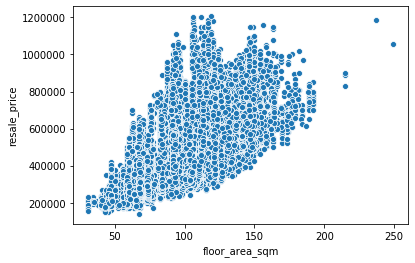

In [8]:
# area vs price
sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price')
#bigger units are more expensive, strong predictor

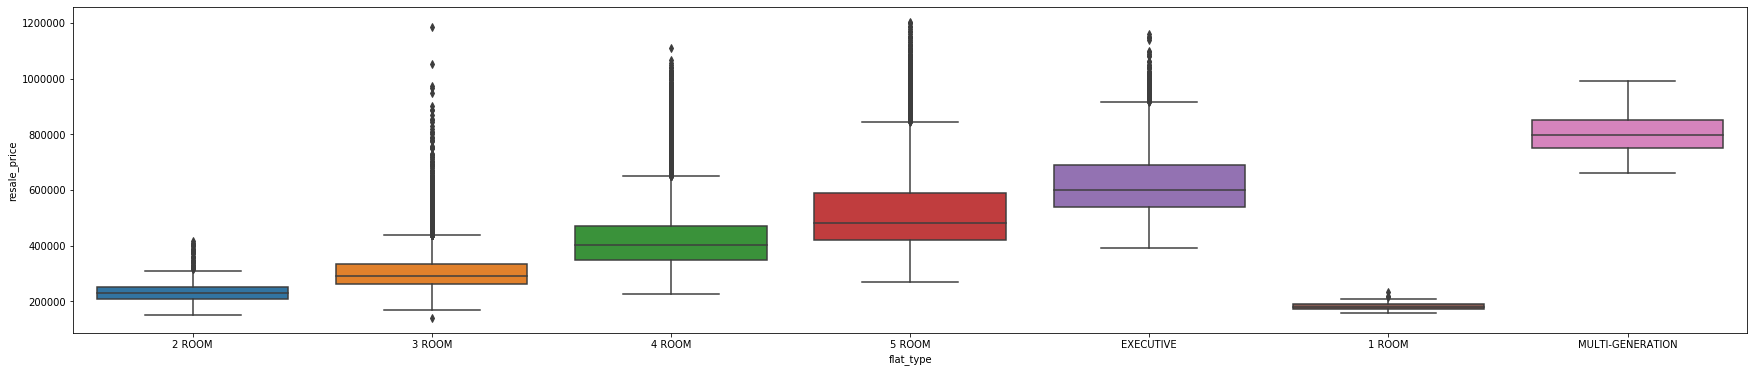

In [9]:
# flat_type vs resale price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_type', y='resale_price')


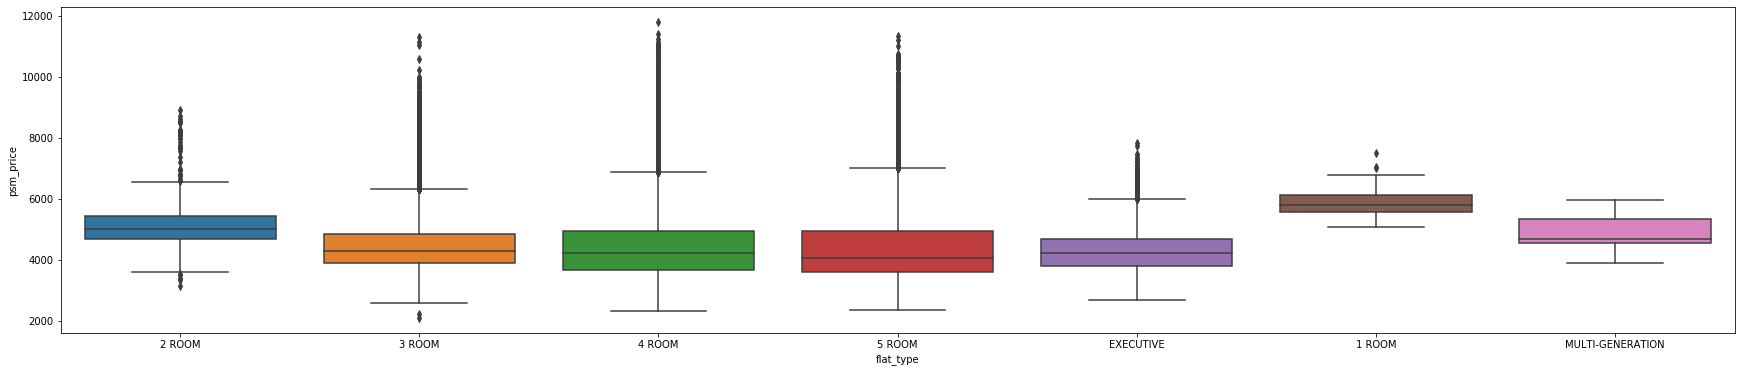

In [10]:
# however the flat type is also highly correlated with size. check the psm_price for each flat type
# flat_type vs psm_price
df.loc[:,'psm_price'] = df.resale_price / df.floor_area_sqm
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_type', y='psm_price')

## after correcting for area, the means of psm_price for most flat types are very similar
## however some flat types still have higher average psm_price 
## - in the particular the small 1/2-room flats, and the multi-gen flats

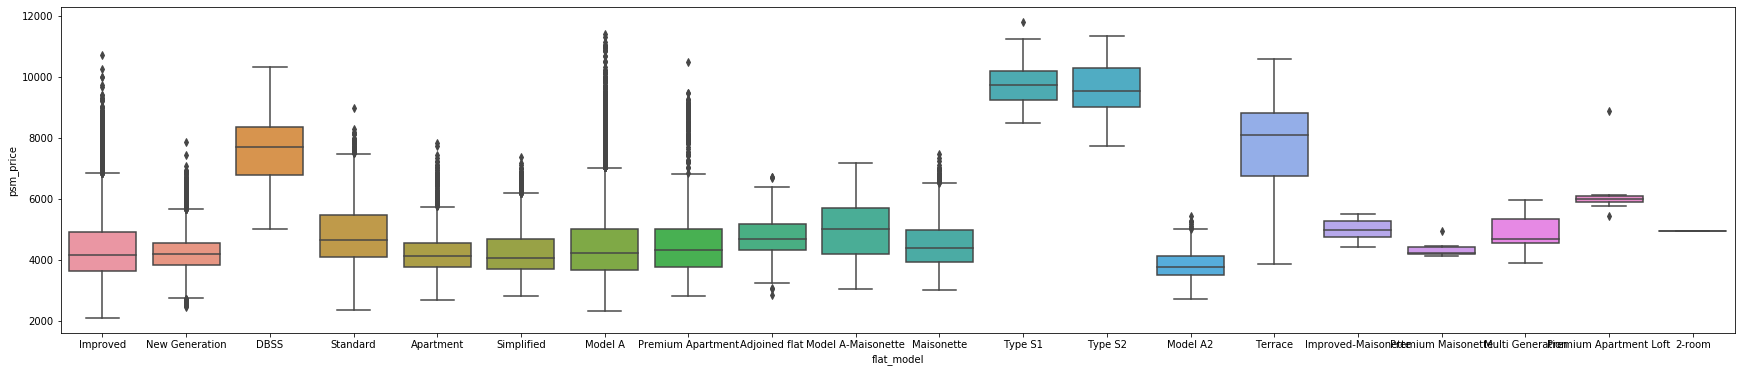

In [11]:
# however the flat type is also highly correlated with size. check the psm_price for each flat type
# flat_type vs psm_price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_model', y='psm_price')

## some flat models like DBSS, Terrace and Type S1/S2 have far higher mean psm_price.
## could be because they are more exclusive. 

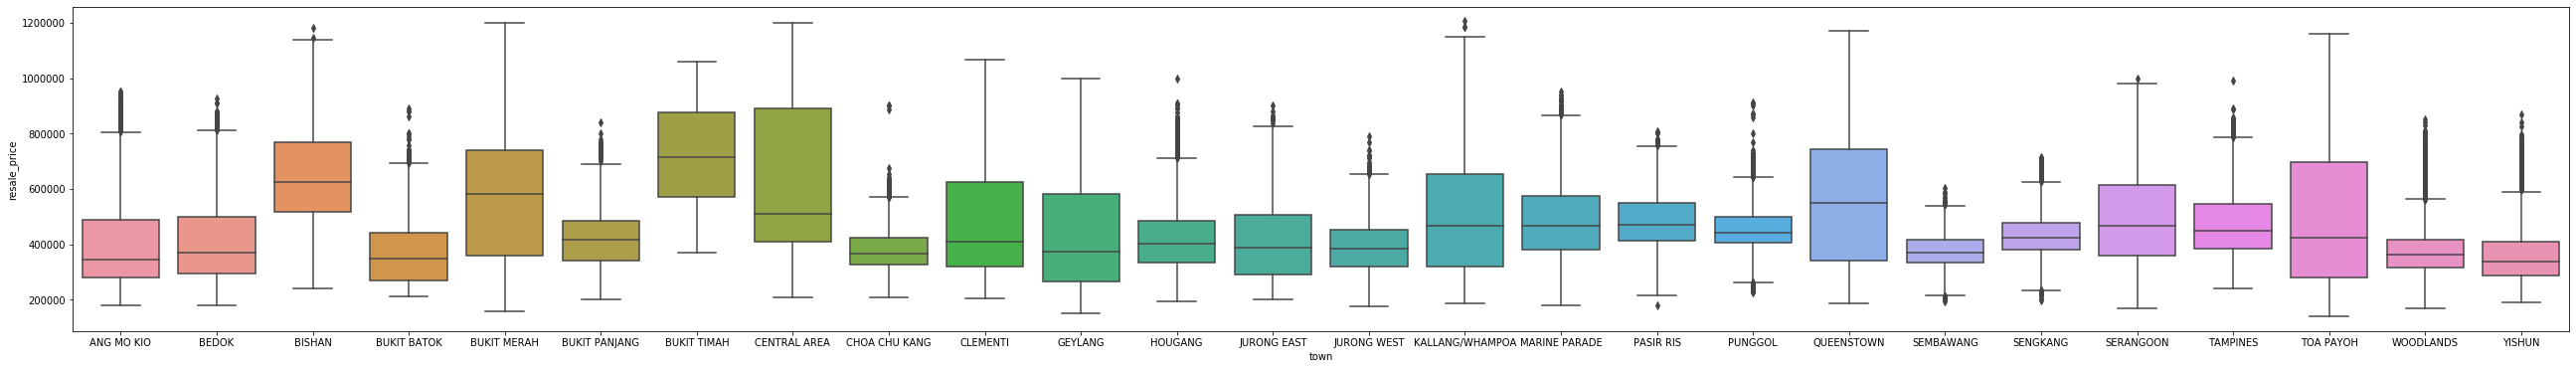

In [12]:
# flat_type vs resale price
plt.figure(figsize=(45, 6))
sns.boxplot(data=df, x='town', y='resale_price')

## there is also significant variation between resale price and town, could be a useful predictor

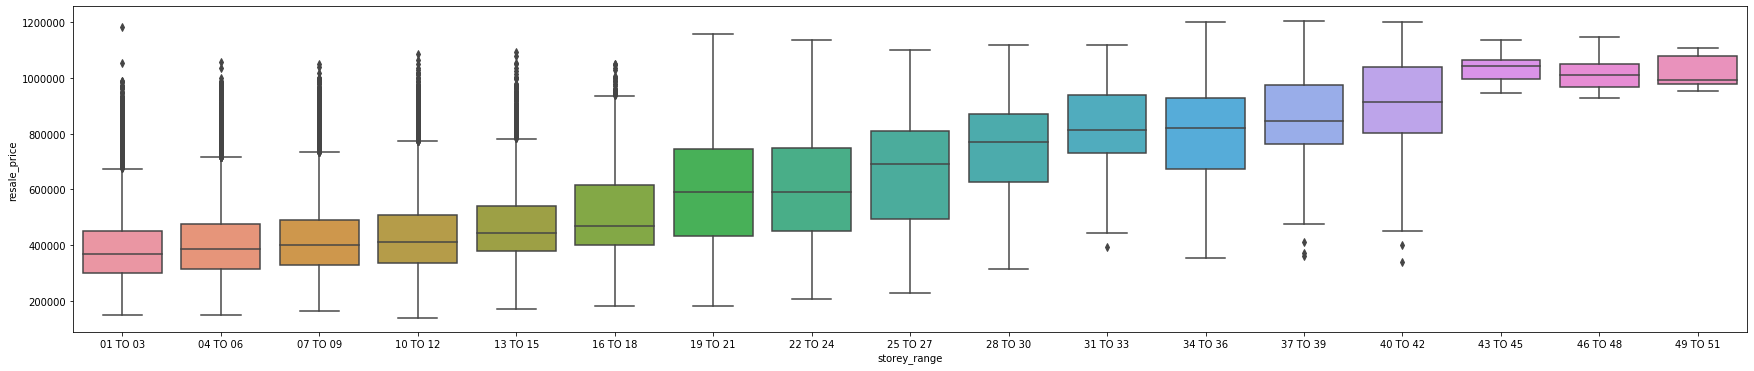

In [13]:
# storey vs resale price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='storey_range', y='resale_price', order=np.sort(df.storey_range.unique()))

## clear relationship that increasing floor level means increasing price

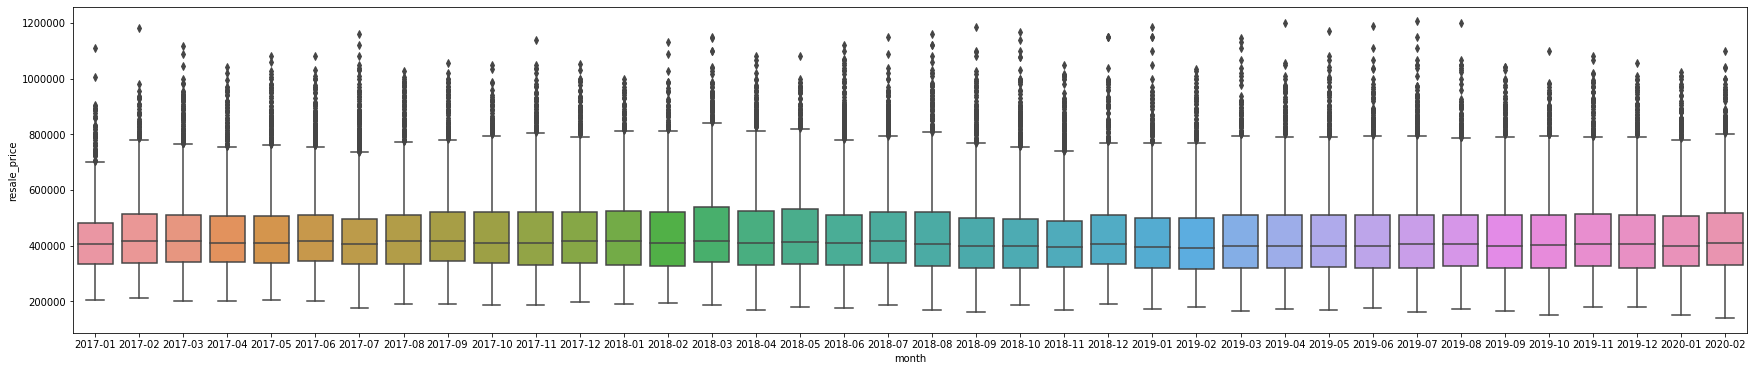

In [14]:
# what about month of sale?
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='month', y='resale_price', order=np.sort(df.month.unique()))

# no clear trend, but check if there is any seasonality within the year

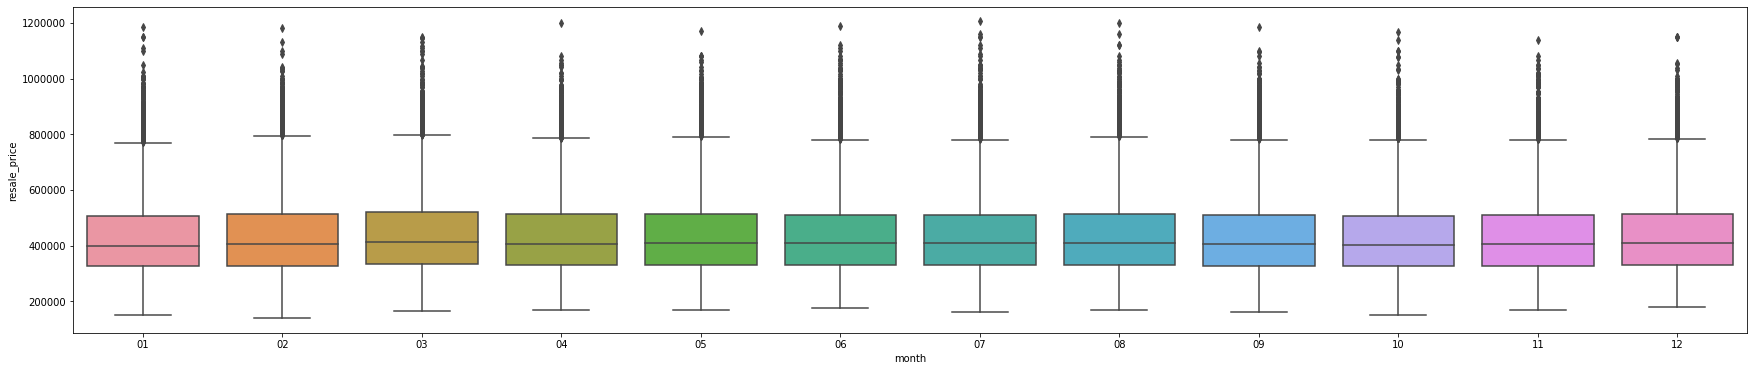

In [15]:
# check if there is any seasonality by month, across the months
plt.figure(figsize=(30, 6))
sns.boxplot(x=df.month.apply(lambda x: x[-2:]), y=df.resale_price)

# no visible trend

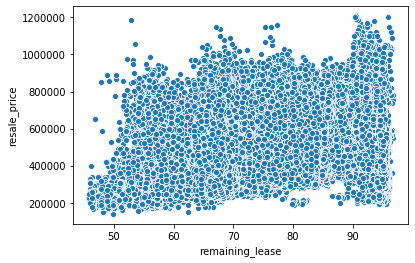

In [16]:
# remaining lease vs resale price
sns.scatterplot(data=df, x='remaining_lease', y='resale_price')

### trend is not so clear, but the higher remaining_lease seems like it tends to have higher resale price.
### can confirm relationship via residual plots after getting an initial model

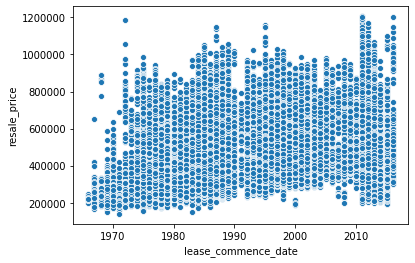

In [17]:
# lease commence date vs resale price
sns.scatterplot(data=df, x='lease_commence_date', y='resale_price')

### similar relationship to remaining_lease as all hdbs flats are sold with 99-year lease
### can probably omit in favour of remaining_lease as remaining_lease as slightly better granularity (months info included)

In [18]:
### baseline prediction of regression model
### using mean price by property type
## the baseline RMSE is calculated from the property price compared to the mean price of its property type 
## calculation is equivalent to std dev with ddof=0
print("baseline prediction:",df['resale_price'].mean())
print("baseline RMSE:",df['resale_price'].std(ddof=0))

baseline prediction: 438863.5022894324
baseline RMSE: 153437.8737270134


## Feature Engineering

In [19]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'psm_price'],
      dtype='object')

In [20]:
### From EDA, can consider predicting two variables: either the resale_price, or psm_price which normalises for area.
## possible dependent variables:
## A. resale_price
## B. psm_price

# possible predictor variables:
# 1. Area
# 2. Town
# 3. Storey
# 4. flat_model
# 5. flat_type (possibly)
# 6. remaining lease / lease commence date

### There are also some other variables that should be important to predicting the resale price:
# 1. distance to MRT or LRT
# 2. distance of nearest MRT/LRT station to the central area
# 3. distance to shopping mall
# 4. distance to supermarket

### Distance to MRT / LRT stations

In [21]:
### to get the distance to MRT, we need the coordinates of the hdb block.
### to do this, pass the address into a geocoding API
### re-use the function from another project that uses onemap API - if fail, try Nominatim - if fail, try google maps
## OneMap is accurate but from experience requires an accurate address, and doesn't contain under-construction properties
## google maps has lowest failure rate but is paid API.
## Nominatim is in between OneMap/Google maps in terms of accuracy, but is free API.
# Since the HDB resale data is so clean, I expect all addresses to work with OneMap API

In [22]:
### first, get the full address of the block by combining block and street name 
df.loc[:,'full_address'] = df.block + " " + df.street_name

In [23]:
#### Function to get address, lat, lon from geocoder APIs

### This code uses Nominatim (openstreetmap) API and geopy package
### However, Nominatim is slow and also doesn't contain many Singapore addresses. Use SLA's onemap instead.
def return_lat_lon_nominatim(address):
    try: 
        address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses onemap api
import requests
import time

def return_lat_lon_openmap(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses Google maps API. But try this the last because it's a paid API
def return_lat_lon_google(address):
    try: 
        address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='SG')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan


#this is the combined function that uses openmap first, then nominatim, then google
def return_lat_lon(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('openmap failed on',address,'trying nominatim')
        try:
            address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
            return address, latitude, longitude
        except:    
            print('nominatim failed on',address,'trying googlemaps')
            try:
                address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='sg')
                return address, latitude, longitude
            except:
                print('google maps failed on',address)
                return np.nan, np.nan, np.nan


In [30]:
print(df.shape)
print(len(df.full_address.value_counts()))

# there are 68161 rows in the data, but only 8693 unique addresses.
# since each unique address would have same coordinates, 
# extract the unique addresses and only pass these into the geocoder API
address_df = df.loc[:,['full_address']].drop_duplicates()

(68161, 13)
8693


In [32]:
# pass addresses into geocoder api
address_df.loc[:,'corrected_address'],address_df.loc[:,'lat'],address_df.loc[:,'lng'] = zip(*address_df.full_address.apply(return_lat_lon))

openmap failed on 3 ST. GEORGE'S RD trying nominatim
openmap failed on 21 ST. GEORGE'S RD trying nominatim
openmap failed on 11 ST. GEORGE'S RD trying nominatim
openmap failed on 8 ST. GEORGE'S LANE trying nominatim
openmap failed on 18 ST. GEORGE'S RD trying nominatim
openmap failed on 15 ST. GEORGE'S RD trying nominatim
openmap failed on 9 ST. GEORGE'S RD trying nominatim
openmap failed on 4B ST. GEORGE'S LANE trying nominatim
openmap failed on 7 ST. GEORGE'S LANE trying nominatim
openmap failed on 5 ST. GEORGE'S LANE trying nominatim
openmap failed on 22 ST. GEORGE'S RD trying nominatim
openmap failed on 20 ST. GEORGE'S RD trying nominatim
openmap failed on 13 ST. GEORGE'S RD trying nominatim
openmap failed on 6 ST. GEORGE'S LANE trying nominatim
openmap failed on 2 ST. GEORGE'S RD trying nominatim
openmap failed on 14 ST. GEORGE'S RD trying nominatim
openmap failed on 23 ST. GEORGE'S RD trying nominatim
openmap failed on 16 ST. GEORGE'S RD trying nominatim
openmap failed on 1 ST. G

In [33]:
### cache results to avoid querying again
address_df.to_csv('cached_hdb_addresses.csv', index=False)

### use this if already cached
# address_df = pd.read_csv('cached_hdb_addresses.csv')

In [36]:
### find mrt coordinates, credits to https://www.kaggle.com/yxlee245/distance-from-hdb-block-address-to-nearest-station
mrt_lrt_df_without_tel = pd.read_csv('mrt_lrt_data.csv')

In [38]:
### reuse function from another project to find distance to closest mrt/lrt and also return the station name and type
# function to find distance between 2 coordinates 
def find_dist(lat1, lon1, lat2, lon2):
    add1 = (lat1,lon1)
    add2 = (lat2,lon2)
    return distance.distance(add1, add2).km

# function that takes in place coordinates and returns the distance to nearest mrt as well as the nearest mrt station
def find_closest_mrt(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values

# function for excluding TEL line
def find_closest_mrt_without_tel(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df_without_tel[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values


In [40]:
# do calculation to find distance to stations
address_df.loc[:,'distance_to_station'],address_df.loc[:,'nearest_station'],address_df.loc[:,'nearest_station_type'] = zip(*address_df.apply(lambda x: find_closest_mrt_without_tel(x['lat'],x['lng']), axis=1))

In [45]:
df = df.drop(['corrected_address','lat','lng'],axis=1)

In [42]:
address_df.columns

Index(['full_address', 'corrected_address', 'lat', 'lng',
       'distance_to_station', 'nearest_station', 'nearest_station_type'],
      dtype='object')

In [46]:
# merge back to df
df = df.merge(address_df, on='full_address',how='left')

In [37]:
# ### functions to use in case we want to consider upcoming TEL stations
# #find upcoming TEL stations coordinates which are not in the above list
# tel_mrt_df = pd.read_csv('tel_mrt_names.csv')

# # find upcoming mrt coordinates using geocoder
# tel_mrt_df.mrt_station_name = tel_mrt_df.mrt_station_name.apply(lambda x: x + " MRT Station")
# tel_mrt_df['address'],tel_mrt_df['lat'],tel_mrt_df['lng'] = zip(*tel_mrt_df.mrt_station_name.apply(return_lat_lon))

# tel_mrt_df = tel_mrt_df.rename(columns = {'mrt_station_name':'station_name'})
# tel_mrt_df.loc[:,'type'] = 'MRT'
# mrt_lrt_df = mrt_lrt_df_without_tel.append(tel_mrt_df, sort=False)
# mrt_lrt_df.to_csv('mrt_lrt_names_combined.csv') # cache for future use to avoid geocoding again

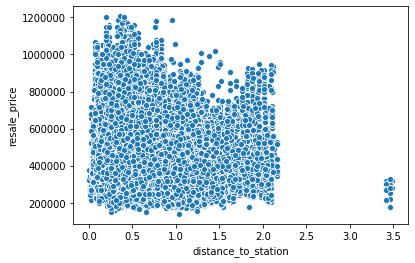

In [56]:
sns.scatterplot(data=df,x='distance_to_station',y='resale_price')

## relationship is not so clear from the scatterplot
## can see that the most expensive flats are quite near (within ~0.8km of station which is roughly 10 min walk away)
## perhaps it only matters whether the station is within walking distance or not
## check relationship later using residual plots

### Distance to Malls

In [4]:
# ### get list of malls https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore
# mall_list = pd.read_csv('malls.csv')

In [6]:
# # get coordinates of malls using function above
# mall_list.loc[:,'full_address'], mall_list.loc[:,'latitude'], mall_list.loc[:,'longitude'] = zip(*mall_list['mall_name'].apply(return_lat_lon))

openmap failed on Clarke Quay Central trying nominatim
openmap failed on City Gate Mall trying nominatim
openmap failed on Holland Village Shopping Mall trying nominatim
nominatim failed on Holland Village Shopping Mall trying googlemaps
openmap failed on Mustafa Shopping Centre trying nominatim
nominatim failed on Mustafa Shopping Centre trying googlemaps
openmap failed on PoMo trying nominatim
openmap failed on Shaw House and Centre trying nominatim
openmap failed on United Square, The Kids Learning Mall trying nominatim
nominatim failed on United Square, The Kids Learning Mall trying googlemaps
openmap failed on myVillage @ Serangoon trying nominatim
openmap failed on Yew Tee Shopping Centre trying nominatim
nominatim failed on Yew Tee Shopping Centre trying googlemaps
openmap failed on KKH The Retail Mall trying nominatim
nominatim failed on KKH The Retail Mall trying googlemaps
openmap failed on Westgate Mall trying nominatim
openmap failed on OD Mall trying nominatim


In [58]:
##can see that some entries are badly named so onemap doesn't have the entries, but nominatim and google maps can pick up the slack.
#mall_list.to_csv('malls_with_coordinates.csv',index=False) #cache results

##retrieve cached results
mall_list = pd.read_csv('malls_with_coordinates.csv')

In [66]:
### define function that takes in place coordinates and returns the nearest shopping mall and distance
def find_closest_mall(property_lat, property_lon):
    temp_mall_df = mall_list[['mall_name','latitude','longitude']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mall_df.loc[:,'distance'] = temp_mall_df.apply(lambda x: find_dist(property_lat, property_lon, x['latitude'], x['longitude']), axis = 1)
    min_idx = temp_mall_df['distance'].idxmin()
    return temp_mall_df.loc[min_idx][['distance','mall_name']].values

In [62]:
address_df

,full_address,corrected_address,lat,lng,distance_to_station,nearest_station,nearest_station_type
0,406 ANG MO KIO AVE 10,406 ANG MO KIO AVENUE 10 HDB-ANG MO KIO SINGAPORE 560406,1.362004539,103.85387990000001,1.007304,Ang Mo Kio,MRT
1,108 ANG MO KIO AVE 4,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SINGAPORE 560108,1.370966352,103.83820190000002,1.271403,Ang Mo Kio,MRT
2,602 ANG MO KIO AVE 5,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SINGAPORE 560602,1.38070883,103.8353682,1.069723,Yio Chu Kang,MRT
3,465 ANG MO KIO AVE 10,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SINGAPORE 560465,1.3662010409999998,103.857201,0.946888,Ang Mo Kio,MRT
4,601 ANG MO KIO AVE 5,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SINGAPORE 560601,1.381041355,103.8351317,1.092582,Yio Chu Kang,MRT
...,...,...,...,...,...,...,...
67772,494D TAMPINES ST 43,494D TAMPINES STREET 43 TAMPINES ALCOVES SINGAPORE 524494,1.363800158,103.95343869999999,0.858550,Tampines East,MRT
67846,485A TAMPINES AVE 9,485A TAMPINES AVENUE 9 HDB-TAMPINES SINGAPORE 520485,1.359893153,103.9557566,0.397480,Tampines East,MRT
68042,811 YISHUN RING RD,811 YISHUN RING ROAD KHATIB GARDENS SINGAPORE 760811,1.4164258859999999,103.83221329999999,0.140442,Khatib,MRT
68117,504C YISHUN ST 51,504C YISHUN STREET 51 ACACIA BREEZE @ YISHUN SINGAPORE 763504,1.417966514,103.8434587,1.166009,Khatib,MRT


In [68]:
# do calculation to find distance to malls
address_df.loc[:,'distance_to_mall'],address_df.loc[:,'nearest_mall'] = zip(*address_df.apply(lambda x: find_closest_mall(x['lat'],x['lng']), axis=1))

In [71]:
df = df.merge(address_df[['full_address','distance_to_mall','nearest_mall']], on='full_address', how='left')

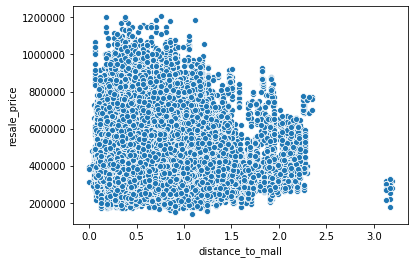

In [72]:
sns.scatterplot(data=df,x='distance_to_mall',y='resale_price')

## the most expensive flats are typically closer to the malls

### Distance to supermarket

In [74]:
### supermarket coordinates are taken from data.gov.sg
# https://data.gov.sg/dataset/supermarkets
kml_file = 'supermarkets-kml.kml'

In [76]:
## data is provided in a kml file. use lxml to parse

from lxml import etree

ns = {"kml": "http://www.opengis.net/kml/2.2"}

tree = etree.parse(kml_file)

supermarket_data = []

for supermarket in tree.findall("//kml:Placemark", namespaces=ns):
    name = supermarket.find(".//kml:SimpleData[@name='LIC_NAME']", namespaces=ns).text
    lng = supermarket.find(".//kml:coordinates",namespaces=ns).text.split(',')[0]
    lat = supermarket.find(".//kml:coordinates",namespaces=ns).text.split(',')[1]
    row = [name,lat,lng]
    supermarket_data.append(row)

column_names = ['supermarket','lat','lng']
supermarket_df = pd.DataFrame(columns = column_names,data=supermarket_data)

In [80]:
### define function that takes in place coordinates and returns the nearest shopping mall and distance
def find_closest_supermarket(property_lat, property_lon):
    temp_supermarket_df = supermarket_df[['supermarket','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_supermarket_df.loc[:,'distance'] = temp_supermarket_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_supermarket_df['distance'].idxmin()
    return temp_supermarket_df.loc[min_idx][['distance','supermarket']].values

In [82]:
# do calculation to find distance to malls
address_df.loc[:,'distance_to_supermarket'],address_df.loc[:,'nearest_supermarket'] = zip(*address_df.apply(lambda x: find_closest_supermarket(x['lat'],x['lng']), axis=1))

In [83]:
df = df.merge(address_df[['full_address','distance_to_supermarket','nearest_supermarket']], on='full_address', how='left')

In [84]:
df.to_csv('hdb_resale_data_with_distances.csv') #cache results to avoid processing in the future

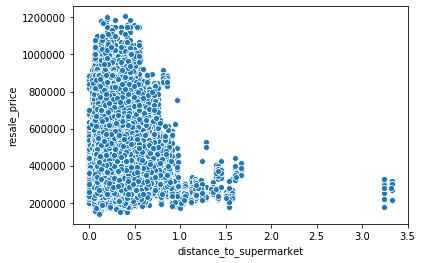

In [86]:
sns.scatterplot(data=df,x='distance_to_supermarket',y='resale_price')

## the most expensive flats are typically closer to the supermarkets

In [ ]:
### GET DISTANCE OF NEAREST STATION TO CBD?

### Dummy Variables for Town, Storey, Flat Model, Flat Type

In [89]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'psm_price', 'full_address',
       'corrected_address', 'lat', 'lng', 'distance_to_station',
       'nearest_station', 'nearest_station_type', 'distance_to_mall',
       'nearest_mall', 'distance_to_supermarket', 'nearest_supermarket'],
      dtype='object')

In [90]:
town_dummies = pd.get_dummies(df['town'], prefix = 'town')
storey_dummies = pd.get_dummies(df['storey_range'], prefix = 'storey')
flat_model_dummies = pd.get_dummies(df['flat_model'], prefix = 'model')
flat_type_dummies = pd.get_dummies(df['flat_type'], prefix = 'type')

## Model

### Linear Regression

In [93]:
## define X and Y vars
model_df = pd.concat([df, town_dummies, storey_dummies, flat_model_dummies, flat_type_dummies], axis=1)
model_df = model_df.drop(['town','storey_range','flat_model','flat_type','month', 'block', 'street_name',\
                          'full_address','corrected_address','lat','lng','nearest_station','nearest_station_type',\
                         'nearest_mall', 'nearest_supermarket'],axis=1)

In [95]:
X = model_df.drop(['resale_price','psm_price'],axis=1)
Y = model_df.resale_price

In [96]:
lin_reg = LinearRegression()

In [97]:
lin_reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
Y_pred = lin_reg.predict(X)

In [99]:
from sklearn.metrics import mean_squared_error, r2_score

In [101]:
resid = Y-Y_pred

In [123]:
X.iloc[:,75]

0        0
1        0
2        0
3        0
4        0
        ..
68156    0
68157    0
68158    0
68159    0
68160    0
Name: type_MULTI-GENERATION, Length: 68161, dtype: uint8

In [125]:
%matplotlib inline

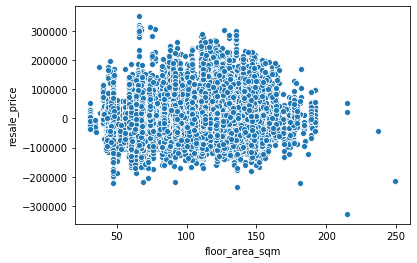

In [129]:
sns.scatterplot(x=col, y=resid)

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


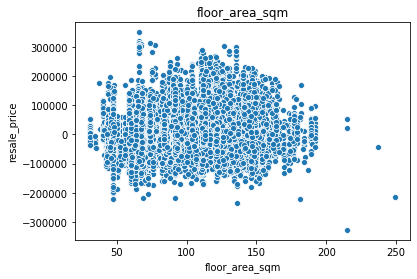

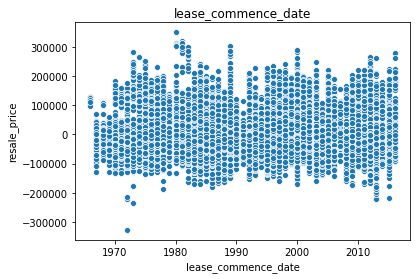

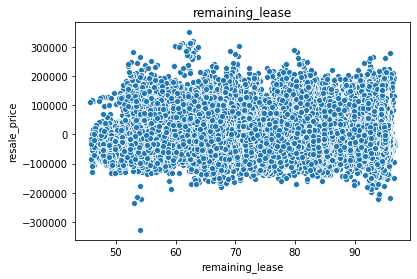

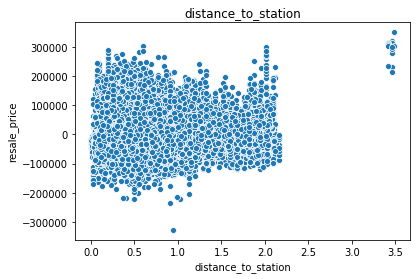

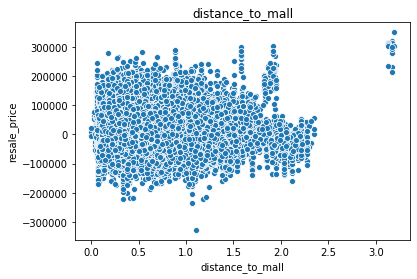

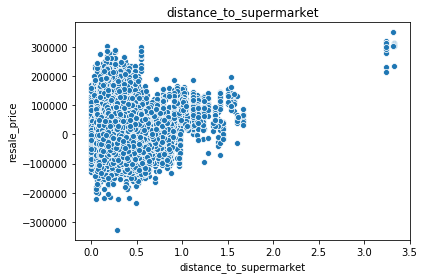

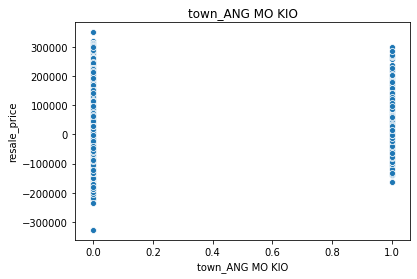

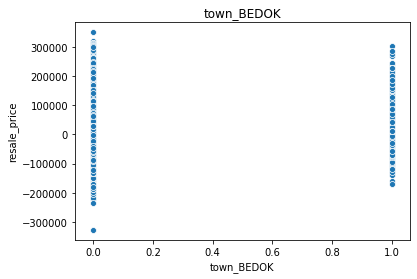

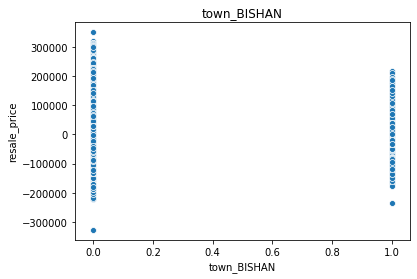

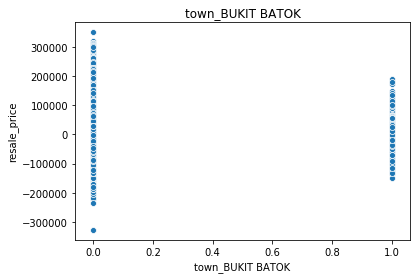

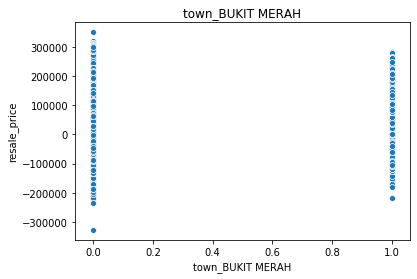

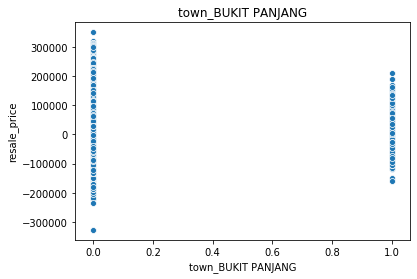

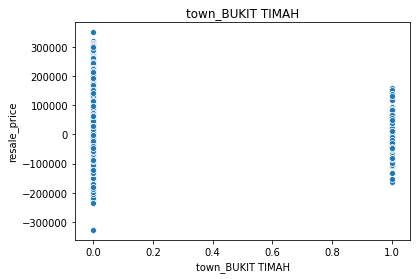

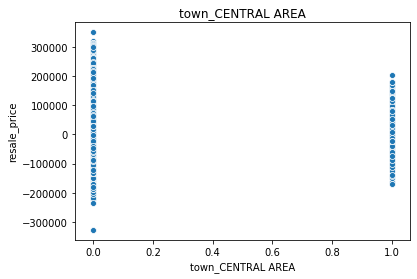

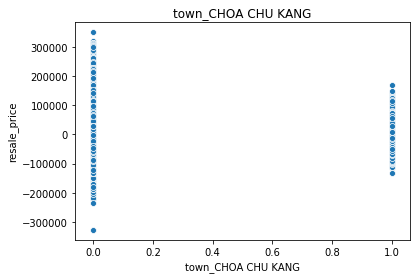

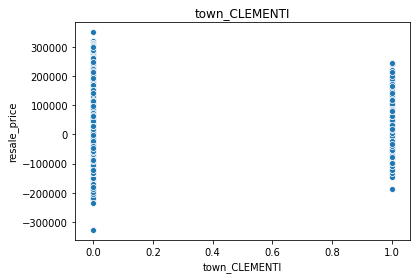

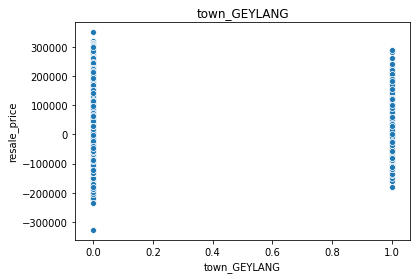

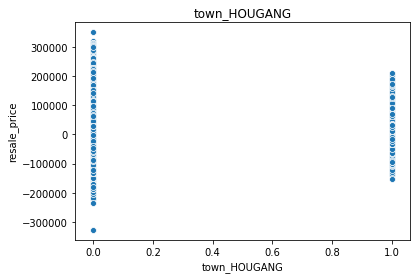

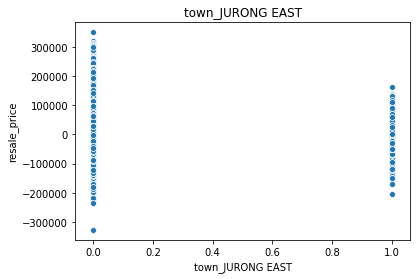

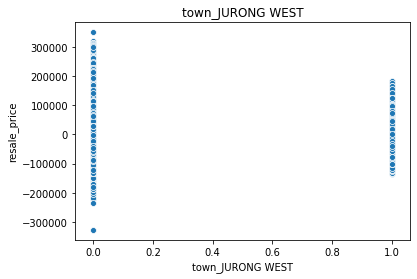

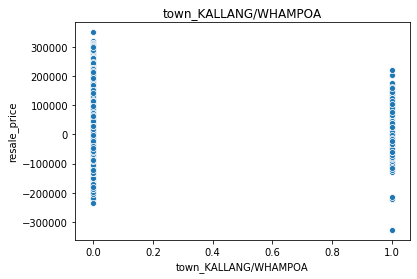

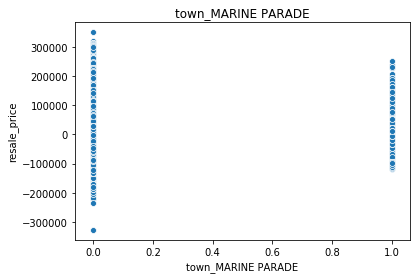

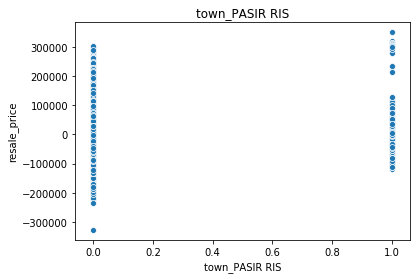

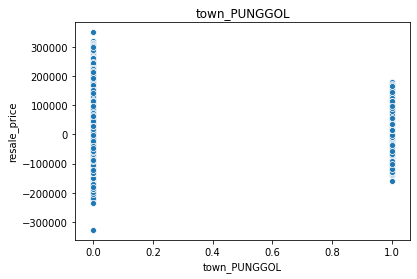

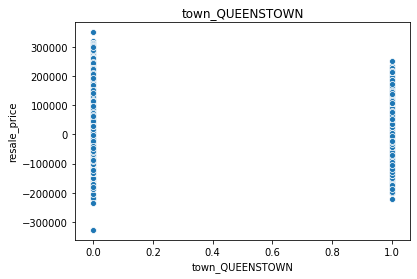

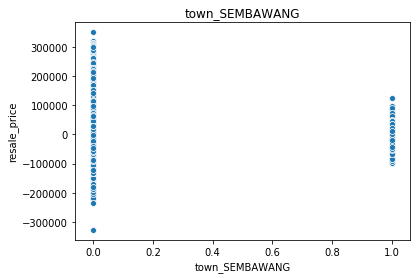

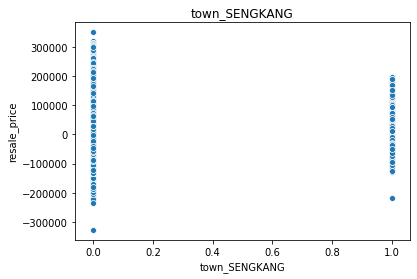

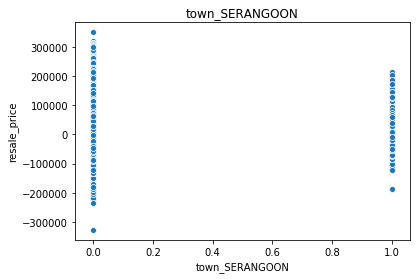

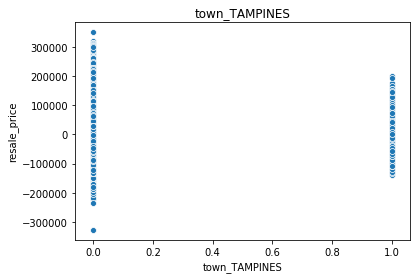

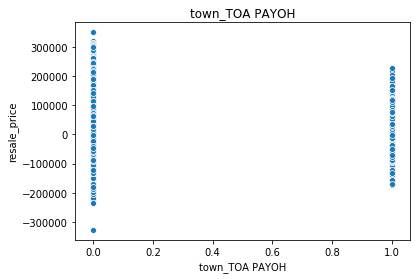

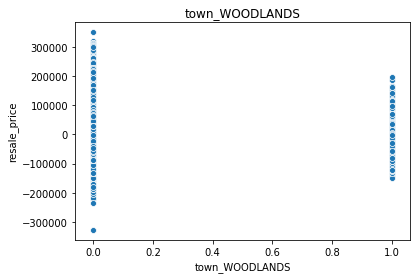

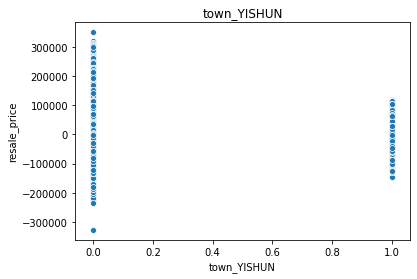

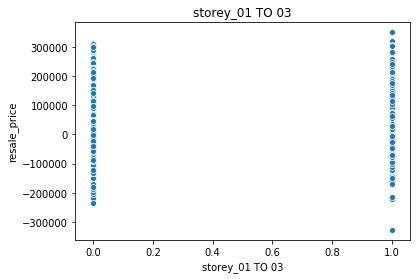

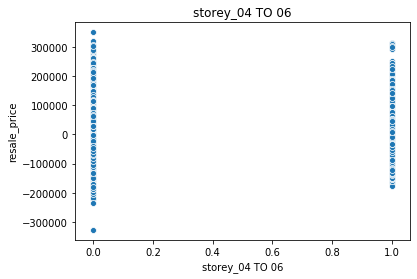

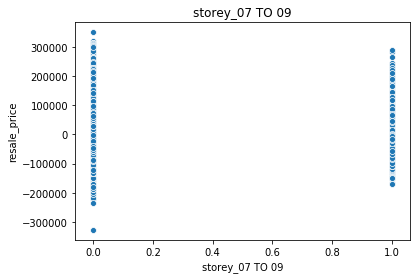

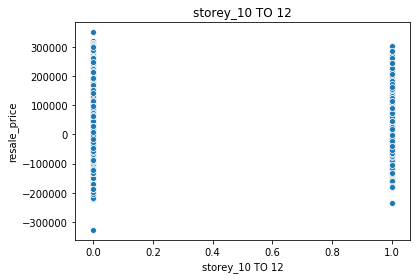

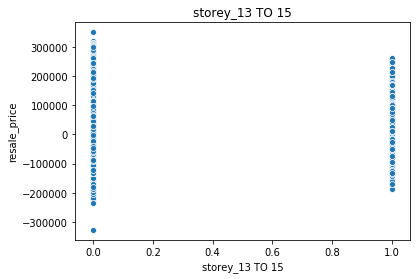

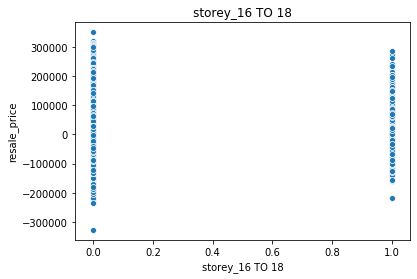

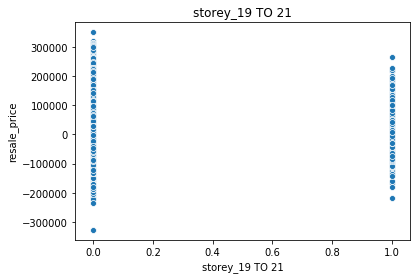

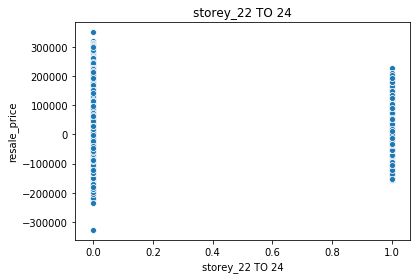

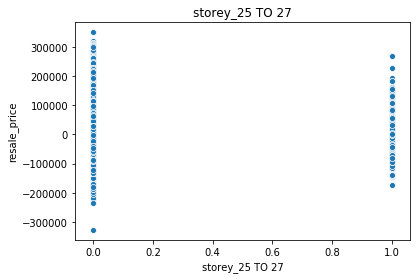

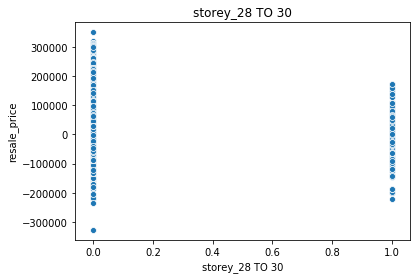

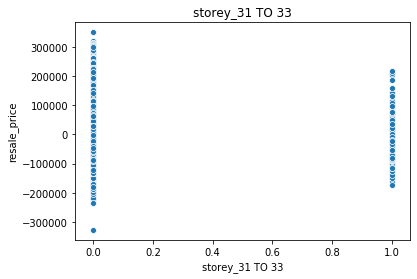

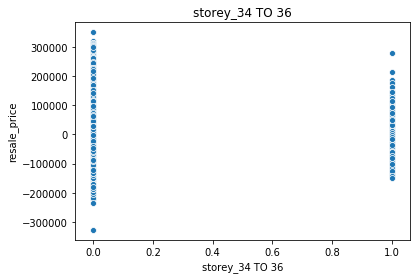

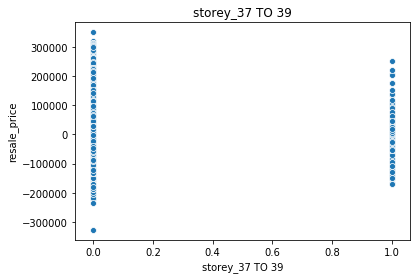

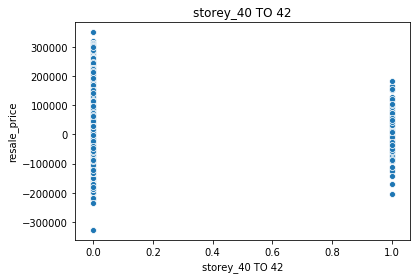

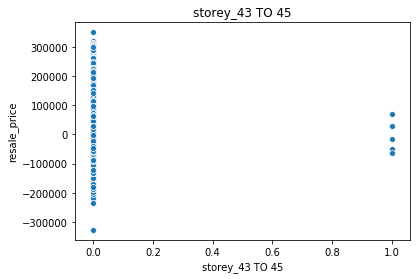

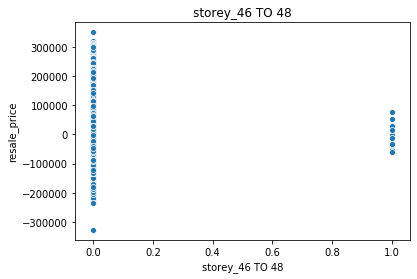

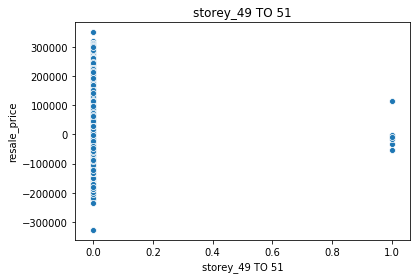

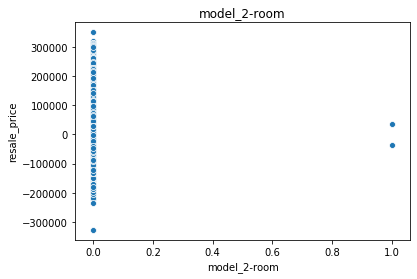

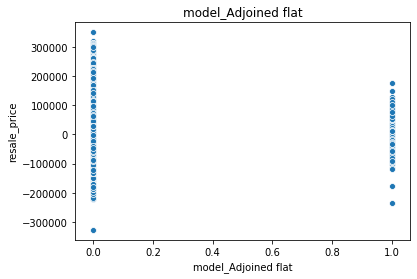

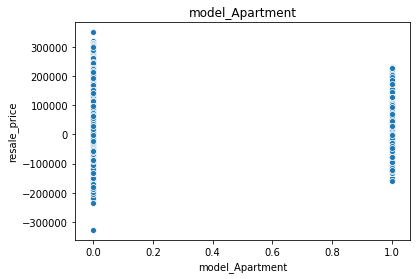

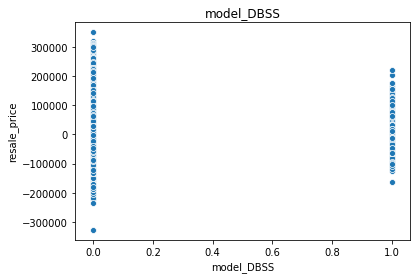

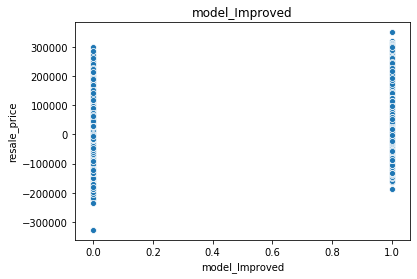

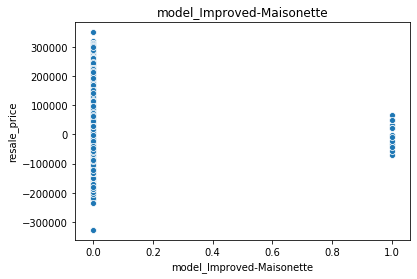

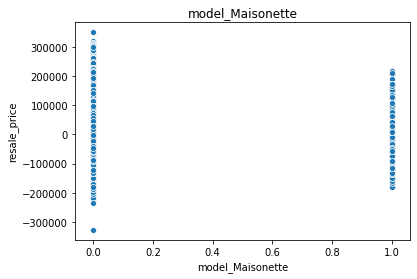

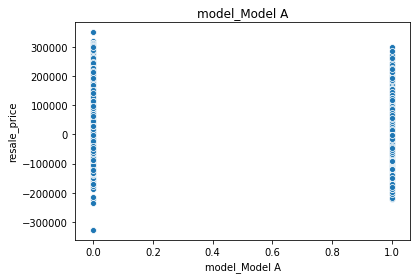

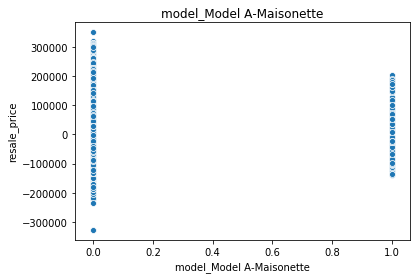

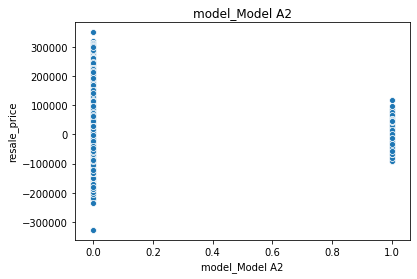

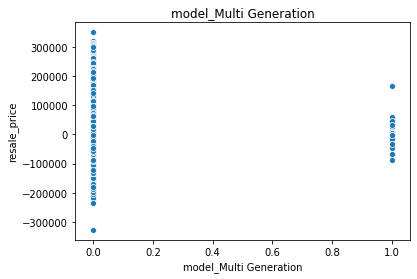

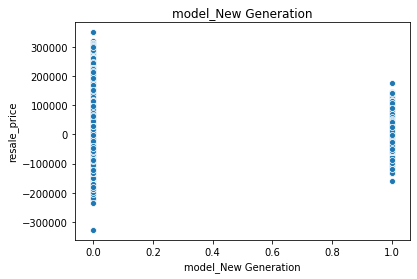

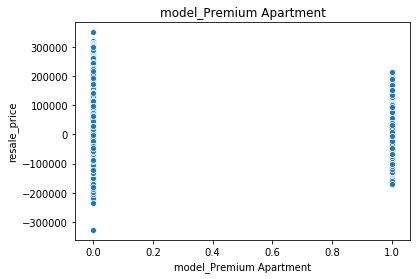

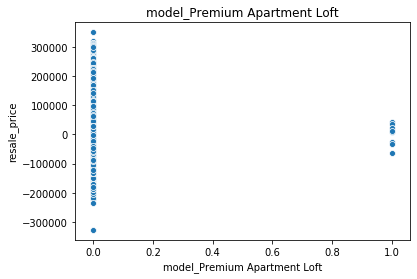

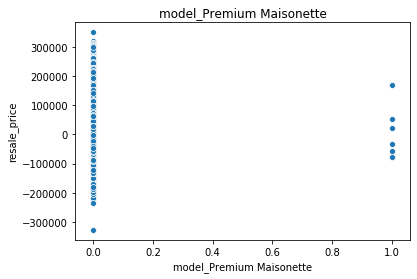

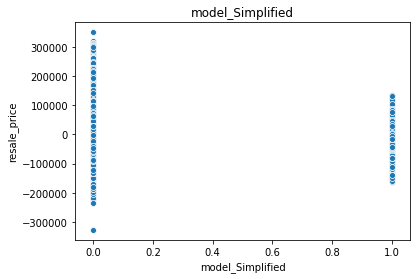

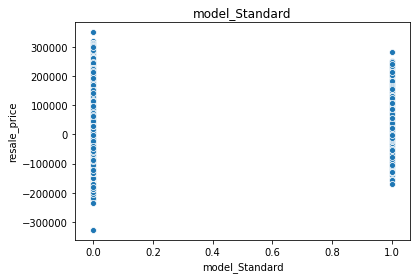

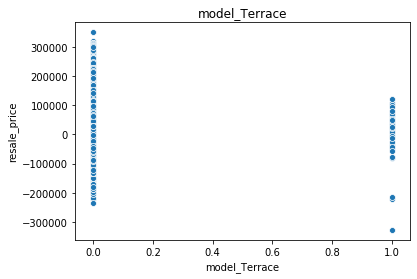

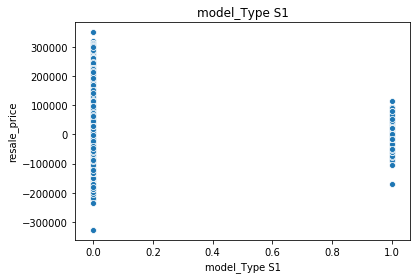

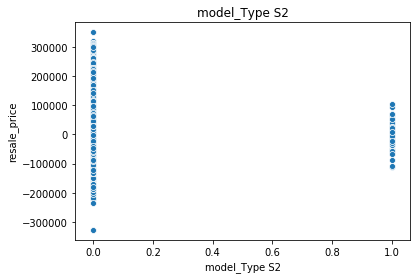

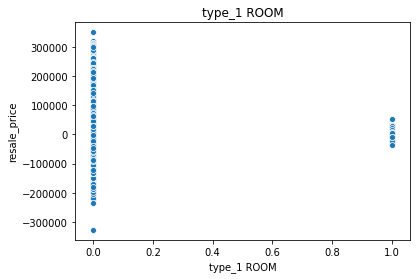

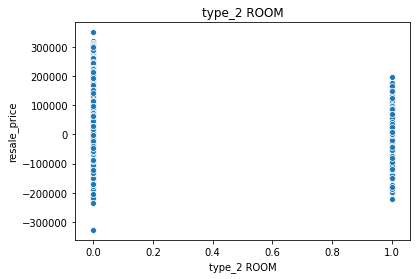

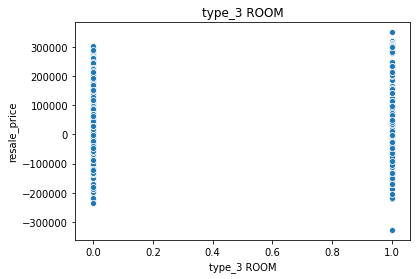

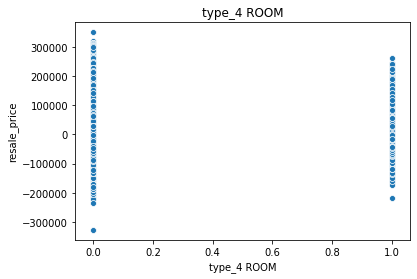

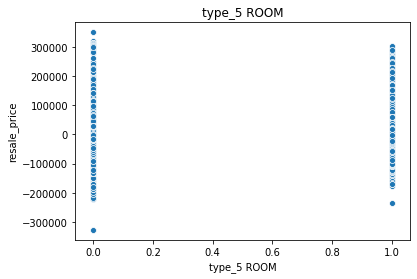

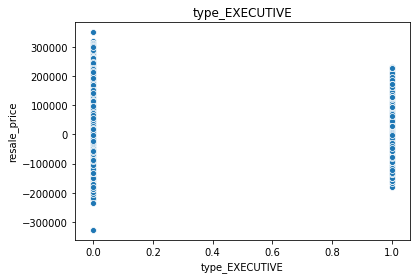

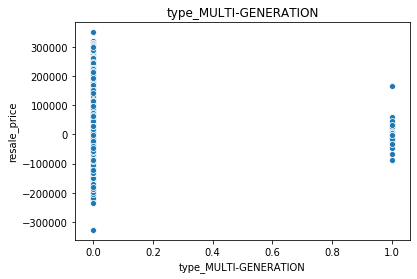

In [130]:
for i, col in enumerate(X.columns):
    plt.figure(i)
    plt.title(col)
    sns.scatterplot(x=col, y=resid,data=model_df)

floor_area_sqm
lease_commence_date
remaining_lease
distance_to_station
distance_to_mall
distance_to_supermarket
town_ANG MO KIO
town_BEDOK
town_BISHAN
town_BUKIT BATOK
town_BUKIT MERAH
town_BUKIT PANJANG
town_BUKIT TIMAH
town_CENTRAL AREA
town_CHOA CHU KANG
town_CLEMENTI
town_GEYLANG
town_HOUGANG
town_JURONG EAST
town_JURONG WEST
town_KALLANG/WHAMPOA
town_MARINE PARADE
town_PASIR RIS
town_PUNGGOL
town_QUEENSTOWN
town_SEMBAWANG
town_SENGKANG
town_SERANGOON
town_TAMPINES
town_TOA PAYOH
town_WOODLANDS
town_YISHUN
storey_01 TO 03
storey_04 TO 06
storey_07 TO 09
storey_10 TO 12
storey_13 TO 15
storey_16 TO 18
storey_19 TO 21
storey_22 TO 24
storey_25 TO 27
storey_28 TO 30
storey_31 TO 33
storey_34 TO 36
storey_37 TO 39
storey_40 TO 42
storey_43 TO 45
storey_46 TO 48
storey_49 TO 51
model_2-room
model_Adjoined flat
model_Apartment
model_DBSS
model_Improved
model_Improved-Maisonette
model_Maisonette
model_Model A
model_Model A-Maisonette
model_Model A2
model_Multi Generation
model_New Generat

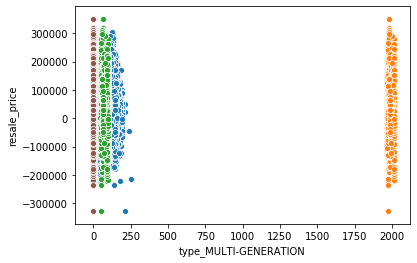

In [126]:
for i in range(len(X.columns)):
    print(X.iloc[:,i].name)
    sns.scatterplot(x=X.iloc[:,i], y=resid)

In [120]:
X.iloc[:,0].name

'floor_area_sqm'

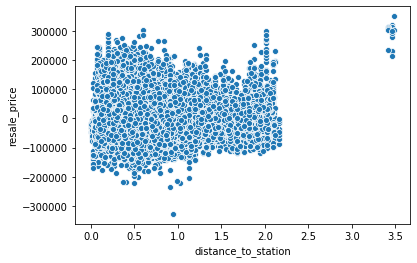

In [104]:
sns.scatterplot(x=X.distance_to_station, y=resid)

In [114]:
for i,d in zip(X.columns,lin_reg.coef_):
    print(i,d)

floor_area_sqm 3512.0213251806304
lease_commence_date 289.34194814009925
remaining_lease 4495.460455365357
distance_to_station -64225.50932309199
distance_to_mall -21339.31018094398
distance_to_supermarket 3427.518988666103
town_ANG MO KIO 29256.313136795183
town_BEDOK 18009.996013997108
town_BISHAN 135074.77974691463
town_BUKIT BATOK -60454.471400675546
town_BUKIT MERAH 127250.7129580226
town_BUKIT PANJANG -141330.5238869244
town_BUKIT TIMAH 209458.8389722848
town_CENTRAL AREA 97269.81669334431
town_CHOA CHU KANG -174410.6352903298
town_CLEMENTI 63728.303149135965
town_GEYLANG 53695.239658171384
town_HOUGANG -50700.354511800084
town_JURONG EAST -23097.367883736653
town_JURONG WEST -104696.97639942044
town_KALLANG/WHAMPOA 69151.10871914533
town_MARINE PARADE 258673.5675079233
town_PASIR RIS -57480.74951215231
town_PUNGGOL -134310.385549344
town_QUEENSTOWN 121526.30807733373
town_SEMBAWANG -178574.1833603395
town_SENGKANG -152579.91061158996
town_SERANGOON 49369.544557142064
town_TAMPIN

In [113]:
print(list(zip(X.columns,lin_reg.coef_)))

[('floor_area_sqm', 3512.0213251806304), ('lease_commence_date', 289.34194814009925), ('remaining_lease', 4495.460455365357), ('distance_to_station', -64225.50932309199), ('distance_to_mall', -21339.31018094398), ('distance_to_supermarket', 3427.518988666103), ('town_ANG MO KIO', 29256.313136795183), ('town_BEDOK', 18009.996013997108), ('town_BISHAN', 135074.77974691463), ('town_BUKIT BATOK', -60454.471400675546), ('town_BUKIT MERAH', 127250.7129580226), ('town_BUKIT PANJANG', -141330.5238869244), ('town_BUKIT TIMAH', 209458.8389722848), ('town_CENTRAL AREA', 97269.81669334431), ('town_CHOA CHU KANG', -174410.6352903298), ('town_CLEMENTI', 63728.303149135965), ('town_GEYLANG', 53695.239658171384), ('town_HOUGANG', -50700.354511800084), ('town_JURONG EAST', -23097.367883736653), ('town_JURONG WEST', -104696.97639942044), ('town_KALLANG/WHAMPOA', 69151.10871914533), ('town_MARINE PARADE', 258673.5675079233), ('town_PASIR RIS', -57480.74951215231), ('town_PUNGGOL', -134310.385549344), ('t

In [100]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(Y, Y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

Coefficients: 
 [   3512.02132518     289.34194814    4495.46045537  -64225.50932309
  -21339.31018094    3427.51898867   29256.3131368    18009.996014
  135074.77974691  -60454.47140068  127250.71295802 -141330.52388692
  209458.83897228   97269.81669334 -174410.63529033   63728.30314914
   53695.23965817  -50700.3545118   -23097.36788374 -104696.97639942
   69151.10871915  258673.56750792  -57480.74951215 -134310.38554934
  121526.30807733 -178574.18336034 -152579.91061159   49369.54455714
  -22120.79519207   67667.80115207 -119438.79348758  -80937.18325633
 -105776.24939014  -88964.28318264  -76454.11670574  -67001.78965188
  -57029.35296024  -42343.0906943   -12857.71771086   -6555.41853144
   10187.52381482   26760.26925007   24418.5657909    37769.90225835
   58633.03184818   74133.51943335   80000.09657289   65460.90614643
   79618.20371226 -105144.30287131  -22675.24872738  -51925.63997956
   33087.18155517  -90731.47033902   96099.22015321  -15041.92329027
  -90018.01069757   

In [ ]:
# previous score

Coefficients: 
 [ 2.62001522e+02  9.05736022e+04  6.23574579e+04  1.40345744e+05
  9.63857538e+04  8.09975271e+04  4.21257814e+04  6.70600402e+04
  1.09613503e+05  1.20604970e+03  1.87179380e+04 -2.61665070e+04
 -1.10519182e+04  3.66779244e+05  1.82887494e+04  1.79639711e+05
 -8.39260481e+04 -8.88936610e+04 -1.60463094e+05 -8.86108889e+04
 -3.35902721e+04  2.31824040e+05  8.76729122e+04  9.07164187e+04
  9.31274536e+04  1.23008955e+05]
Root mean squared error: 143435.30
Coefficient of determination: 0.46

In [241]:
hdb_X_df.columns

Index(['area', 'bathrooms', 'bedrooms', 'distance_to_station', 'district_D1',
       'district_D10', 'district_D12', 'district_D13', 'district_D14',
       'district_D15', 'district_D16', 'district_D17', 'district_D18',
       'district_D19', 'district_D2', 'district_D20', 'district_D21',
       'district_D22', 'district_D23', 'district_D25', 'district_D27',
       'district_D28', 'district_D3', 'district_D4', 'district_D5',
       'district_D7', 'district_D8'],
      dtype='object')

In [239]:
hdb_model_df.price.describe()

count    7.518000e+03
mean     5.341399e+05
std      1.957209e+05
min      2.180000e+05
25%      4.000000e+05
50%      5.000000e+05
75%      6.380000e+05
max      4.000000e+06
Name: price, dtype: float64

In [245]:
hdb_model_df[hdb_model_df.district_D12==1]

,area,bathrooms,bedrooms,price,psf_price,distance_to_station,district_D1,district_D10,district_D12,district_D13,...,district_D22,district_D23,district_D25,district_D27,district_D28,district_D3,district_D4,district_D5,district_D7,district_D8
16275,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16276,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16277,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16278,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16279,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23812,830,1.0,2.0,325000.0,392,0.429136,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23842,1302,2.0,3.0,650000.0,499,0.314439,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23922,1129,2.0,3.0,720000.0,638,0.371862,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23925,721,2.0,2.0,260000.0,361,0.745808,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
hdb_df[hdb_df.area<200]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
16356,Singapore 611138,"High Floor,Bomb Shelter",105,2.0,3.0,"*Exclusive Listing*\nUnique security feature with Access Control to lift lobby only to residence. \n5-minute drive to AYE expressway.\nExclusively Rare Unit for investment and own staying\n5R DBSS Model\n*3 bed rooms + 2 bath rooms \n*Square living room and spacious layout.\n*Fully renovated and well maintained.\n*Nearest MRT: Lakeside MRT and Boon Lay MRT.\n*Proximity to many educational institutions such as:\nJurong Secondary School\nLakeside Primary School\nNational Technological University\n*Easy reach and Minutes’ walk to Superbowl Jurong, Jurong Lake Gardens, Taman Jurong Park, Taman Jurong Shopping Centre, Taman Jurong Market and Food Centre.\n*Unblock good view to vicinity.\nCall to view at 9765 2941","Availability,Now,Lease,Flexible",- 99 years,https://www.99.co/singapore/sale/property/138a-yuan-ching-road-hdb-i8HuwBFWkzCJRt7h6huvPa,138A Yuan Ching Road,...,NaN,None,,99 years,138A YUAN CHING ROAD LAKE VISTA @ YUAN CHING SINGAPORE 611138,1.327937,103.724178,1.844158,Lakeside,MRT
16598,Singapore 470769,"High Floor,Bomb Shelter,Corner Unit,Renovated",118,2.0,3.0,"769 Bedok Reservoir View living close to Reservoir Nature & Downtown MRT (Bedok Reservoir), 5I CORNER sitting on high floor. Living hall & Master partial canal view & Kitchen / Common Room unblock view. The entire house come with impressive functional layout of 115sqm & fully renovated, living hall / kitchen is rectangular shape and brightly lit and in all bedrooms too, allowing enough natural lightings into the unit and almost unblock, squarish layout in all bedrooms which is enough to put K'size bed in all bedroom and kitchen come with service yard for laundry. Renovation was done in 2011 (8 Years) with fully functional kitchen L-Shape top/bottom cabinet with built-in oven, stove and hood. Very well segregated layout for living and dining. Kitchen wall can be knocked down in the event you would like to have open concept kitchen. Master room & 1 Common Room come with a Built-in closet with plentiful of storage and drawer from floor to ceiling. Owner is a middle age chinese family, if you enjoy the serenity of the location yet is stone throw away to amenities (NTUC, coffeeshops, Mac, Guardians, Clinic, Hardware, Confectionery etc..).\n\n* 530m Away from Bedok Reservoir MRT (Downtown Line), 5-6 mins walk to MRT\n* 1.5km Away from Amenities (Blk 739-746 HDB Shophouses)\n* Within 1km Schools (Temasek Poly, Bedok Green Sec, Red Swastika Sch, Saint Anothony’s Canossian Sec)\n\n* HDB 5I Model\n* 1,237 Sqft / 115 Sqm\n* 3 Bedroom 2 Bathroom Service Yard Bomb Shelter\n* High Floor\n* CORNER (Corridor End Last Unit)\n* Impressive Layout (Regular & Squarish Layout)\n* Aircon (4 Split Unit) in all bedrooms & Living Hall\n* Well Kept Condition\n* Tastefully Renovated (8 Years Only)\n* Living with Homogeneous Tiles & All Bedrooms Parquet Flooring\n* Chinese House\n* TOP 2000 (19yo Flat / Balance 80 Years)\n* Serious Seller (Looking to Upgrade to 5 Room)\n\nInterested Cobroke Agent / Buyer:\nFor Quick Respond!\n\nPlease Call / SMS / WhatsApp Khayden @ 65 9423 0967 (Propnex) \nCEA Reg No: R015159B","Facing,North South,Availability,Now,District,D16",2000 - 99 years,https://www.99.co/singapore/sale/property/769-bedok-reservoir-view-hdb-yskfE6Gd7GPTfYL6ApX4c7,769 Bedok Reservoir View,...,NaN,None,2000,99 years,769 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470769,1.335779,103.937912,0.546318,Bedok Reservoir,MRT
16599,Singapore 470769,"High Floor,Bomb Shelter,Corner Unit,Renovated",118,2.0,3.0,"769 Bedok Reservoir View living close to Reservoir Nature & Downtown MRT (Bedok Reservoir), 5I CORNER sitting on high floor. Living hall & Master partial canal view & Kitchen / Common Room unblock view. The entire house c

In [262]:
hdb_df[(hdb_df.psf_price>3000)&(hdb_df.area>200)]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
19493,Singapore 650419,"High Floor,Stove,Bomb Shelter,Renovated,Aircon",893,2.0,3.0,"Exclusive 4S unit high floor for sale. \nNo odd shape \n\nWindy & bright unit. \nLarge size with only one neighbour beside u\nMaster bedroom with attached toilet \n\nEnjoy amenities such as shops, supermarkets and coffeeshop right at your doorstep. \nWide array of buses to get u to anywhere. Alternatively 12 mins walk to Bukit Gombak MRT. \n\nFor viewing pls call/text Irene @ 9631 7367 for appt","Availability,Now,District,D23",1986 -,https://www.99.co/singapore/sale/property/419-bukit-batok-west-avenue-2-hdb-JNhjFvHXLhqtETyMsrjSJG,419 Bukit Batok West Avenue 2,...,NaN,None,1986,,419 BUKIT BATOK WEST AVENUE 2 HDB-BUKIT BATOK SINGAPORE 650419,1.361947,103.746196,0.707692,Bukit Gombak,MRT
21780,Singapore 820133,"High Floor,Renovated",980,2.0,3.0,"133 Edgedale Fields - 4 Room Flat for Sale\n\nHigh floor\nWindy\nUnblock \nMinutes Walk to Coral Edge LRT and 3 Stops to Punggol MRT\nNear to Punggol 21, Punggol Plaza and lots of amenities \nViewing by appointment \n\nPlease call Simmone 9146 2435 for viewing appointment","Facing,North South,Availability,Now,District,D19",2003 -,https://www.99.co/singapore/sale/property/133-edgedale-plains-hdb-69gk4Y4rN2Fm6xjUBY8EGV,133 Edgedale Plains,...,NaN,None,2003,,133 EDGEDALE PLAINS HDB-PUNGGOL SINGAPORE 820133,1.392832,103.910620,0.254294,Coral Edge,LRT


In [285]:
hdb_df[hdb_df.distance_to_station>3.4]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
17741,Singapore 500004,NaN,721,1.0,2.0,Attention To all 1st Timer!\nThis unit is BELOW $250K after CPF HOUSING GRANT.\n\nResort Living Lifestyle!\nStaycation everyday.\n\nGrap this unique low rise HDB at Changi Village.\nYour backyard is the sea and the beach..\nGreat Nasi Lemak and many more good food within walking distance.\n\nCall Katherine Neo @ 90073137 for viewing.\nCan CONTRA\n,"Furnishing,Partially Furnished,Availability,Now,District,D17",1980 - 99 years,https://www.99.co/singapore/sale/property/4-changi-village-road-hdb-oXeFML49hWyQB4CSerUenA,4 Changi Village Road,...,NaN,None,1980,99 years,4 CHANGI VILLAGE ROAD HDB-CHANGI VILLAGE ROV SINGAPORE 500004,1.389096,103.987463,3.482140,Changi Airport,MRT
17742,Singapore 500004,Renovated,721,1.0,2.0,"Attention To All 1st Timer!\nThis unit is BELOW $250k after CPF family grant \n\n\nStaycation Everyday!\n\n2 mins walk to the SEA and the Beach.\nBest Nasi Lemak and many good food at nearby eateries.\n\nRenovated unit , windy.\n\nCan Contra.\nCall Katherine Neo @ 90073137 for viewing.\n","Furnishing,Partially Furnished,Availability,Now,District,D17",1980 - 99 years,https://www.99.co/singapore/sale/property/4-changi-village-road-hdb-8pzGRqvvY8oPM8QsX7aoCi,4 Changi Village Road,...,NaN,None,1980,99 years,4 CHANGI VILLAGE ROAD HDB-CHANGI VILLAGE ROV SINGAPORE 500004,1.389096,103.987463,3.482140,Changi Airport,MRT
23339,Singapore 500005,NaN,710,1.0,2.0,Rare 3 Room for sale 5 Changi village 3rd floor lift level \n\nResort living \n\nBus service 9/89/19/2/59/109\n\nwalking distance Changi beach wet market Hawkers center shop 711 24 hours \n\nEasy excess to Tampines/Pasir Ris Mrt white sand mall \n\nDon’t Miss call 91473018 \n\nYussaini Slp Scotia \n\nAssociate Director \n\nR011432H,"Furnishing,Unfurnished,District,D17",1981 - 99 years,https://www.99.co/singapore/sale/property/5-changi-village-road-hdb-LeoD7it6RooXfb3xGguHu,5 Changi Village Road,...,NaN,None,1981,99 years,5 CHANGI VILLAGE ROAD SINGAPORE 500005,1.388853,103.986846,3.458235,Changi Airport,MRT


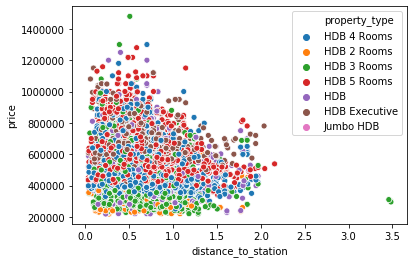

In [283]:
sns.scatterplot(x='distance_to_station',y='price',data=hdb_df[(hdb_df.area>200)&(hdb_df.psf_price<2500)&(hdb_df.price<1.5e6)], hue='property_type')

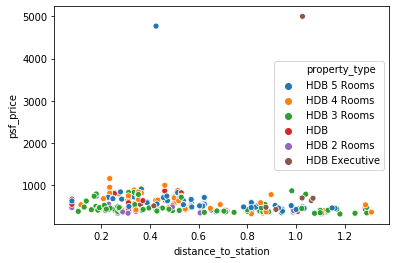

In [290]:
sns.scatterplot(x='distance_to_station',y='psf_price',data=hdb_df[hdb_df.district=='D12'], hue='property_type')

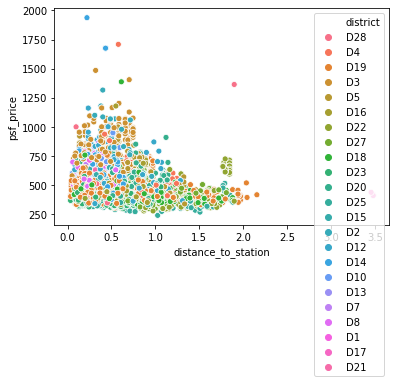

In [264]:
sns.scatterplot(x='distance_to_station',y='psf_price',data=hdb_df[(hdb_df.area>200)&(hdb_df.psf_price<2500)], hue='district')

In [ ]:
# print(__doc__)


# # Code source: Jaques Grobler
# # License: BSD 3 clause


# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the diabetes dataset
# diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# # Use only one feature
# diabetes_X = diabetes_X[:, np.newaxis, 2]

# # Split the data into training/testing sets
# diabetes_X_train = diabetes_X[:-20]
# diabetes_X_test = diabetes_X[-20:]

# # Split the targets into training/testing sets
# diabetes_y_train = diabetes_y[:-20]
# diabetes_y_test = diabetes_y[-20:]

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# # Make predictions using the testing set
# diabetes_y_pred = regr.predict(diabetes_X_test)

# # The coefficients
# print('Coefficients: \n', regr.coef_)
# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(diabetes_y_test, diabetes_y_pred))

# # Plot outputs
# plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
# plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()